# Projecting 2025 HRs for Cal Raleigh using Beta-Binomial
This notebook contains the code for our first modeling approach, beta-binomial

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

In [11]:
import sys
sys.path.append('..')
from src.processing import load_data, get_player_career_stats
from src.modeling import fit_beta_prior, run_beta_binomial_model, simulate_season


In [12]:
sns.set_style("whitegrid")

In [13]:
df = load_data()

In [14]:
df.head()

,Season,Name,Team,Name.1,Team.1,Season.1,Age,PA,HR,BB%,SLG,ISO,Med%,Hard%,Barrel%,HardHit%,NameASCII,PlayerId,MLBAMID
0,2015,Carlos Beltrán,NYY,Carlos Beltrán,NYY,2015,38,531,19,0.084746,0.470711,0.194561,0.533835,0.333333,0.042607,0.418546,Carlos Beltran,589,136860
1,2015,Adrian Beltré,TEX,Adrian Beltré,TEX,2015,36,619,18,0.066236,0.453263,0.165785,0.519608,0.337255,0.049020,0.401961,Adrian Beltre,639,134181
2,2015,Torii Hunter,MIN,Torii Hunter,MIN,2015,39,567,22,0.061728,0.408829,0.168906,0.529691,0.289786,0.047506,0.346793,Torii Hunter,731,116338
3,2015,David Ortiz,BOS,David Ortiz,BOS,2015,39,614,37,0.125407,0.553030,0.280303,0.463801,0.418552,0.124434,0.493213,David Ortiz,745,120074
4,2015,Todd Frazier,CIN,Todd Frazier,CIN,2015,29,678,35,0.064897,0.497577,0.242326,0.442857,0.373469,0.081633,0.385714,Todd Frazier,785,453943


In [15]:
df.columns

Index(['Season', 'Name', 'Team', 'Name.1', 'Team.1', 'Season.1', 'Age', 'PA',
       'HR', 'BB%', 'SLG', 'ISO', 'Med%', 'Hard%', 'Barrel%', 'HardHit%',
       'NameASCII', 'PlayerId', 'MLBAMID'],
      dtype='object')

In [16]:
df.drop(columns=["Name.1", "Team.1", "Season.1", "NameASCII", 'PlayerId', 'MLBAMID'], inplace=True)
league_df = df[df['PA'] > 250]

In [17]:
league_df['HR_RATE'] = league_df['HR'] / league_df['PA']

/tmp/ipykernel_25106/3602446079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_df['HR_RATE'] = league_df['HR'] / league_df['PA']


In [18]:
prior_alpha, prior_beta = fit_beta_prior(league_df)
print(f"Beta Prior Parameters (from league data): alpha = {prior_alpha:.2f}, beta = {prior_beta:.2f}")

Beta Prior Parameters (from league data): alpha = 5.19, beta = 139.35


In [19]:
cal_career_stats = get_player_career_stats(df, 'Cal Raleigh', end_year=2024)
print("\n--- Cal Raleigh's Career Stats (up to 2024) ---")
print(f"Total PA: {cal_career_stats['PA']}")
print(f"Total HR: {cal_career_stats['HR']}")
print(f"Career HR Rate: {cal_career_stats['HR_RATE']:.4f}")


--- Cal Raleigh's Career Stats (up to 2024) ---
Total PA: 1197
Total HR: 64
Career HR Rate: 0.0535


## --- Approach 1: Hypothetical Projections based on Career Stats ---

Initializing NUTS using jitter+adapt_diag...



--- Running Hypothetical Simulation (Approach 1) ---


Sequential sampling (4 chains in 1 job)
NUTS: [theta]


/home/abarel/virtualenvs/mcmc-baseball/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 2 seconds.


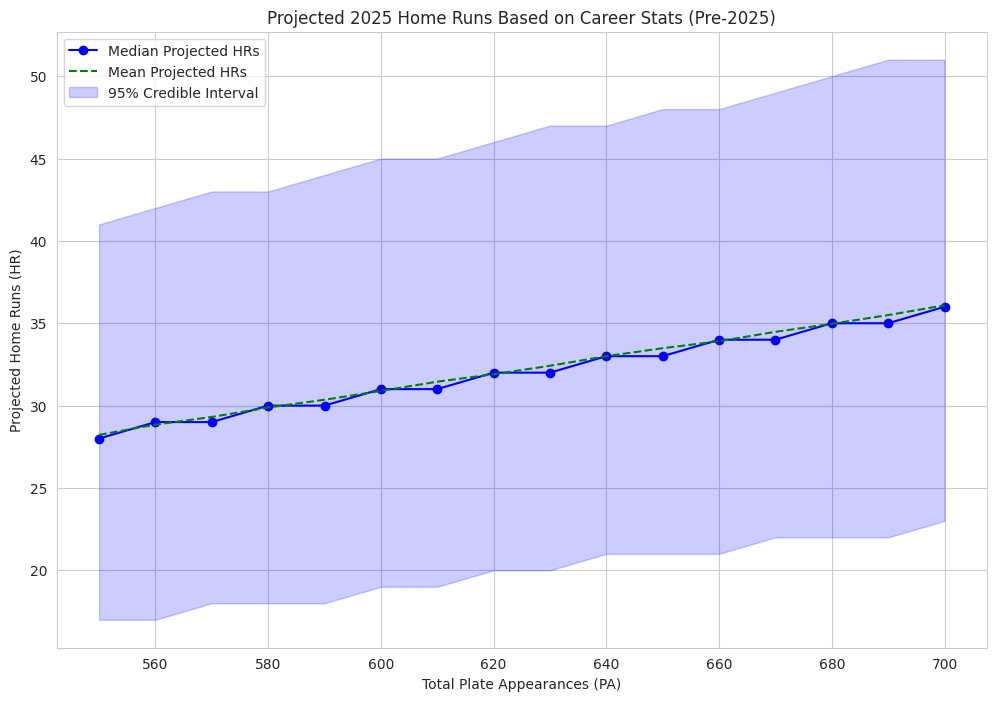

In [20]:
print("\n--- Running Hypothetical Simulation (Approach 1) ---")

# Step A: Run the model using Cal's career stats as the observed data
# This model will represent our belief about his HR rate before the 2025 season
player_stats_career = {'HR': cal_career_stats['HR'], 'PA': cal_career_stats['PA']}
idata_career = run_beta_binomial_model(player_stats_career, prior_alpha, prior_beta)

# Step B: Simulate season outcomes for a range of total plate appearances
pa_range = range(550, 701, 10)
simulated_hr_means = []
simulated_hr_medians = []
simulated_hr_95_ci_low = []
simulated_hr_95_ci_high = []

for total_pa in pa_range:
    simulated_hrs = simulate_season(idata_career, total_pa)
    simulated_hr_means.append(np.mean(simulated_hrs))
    simulated_hr_medians.append(np.median(simulated_hrs))
    simulated_hr_95_ci_low.append(np.percentile(simulated_hrs, 2.5))
    simulated_hr_95_ci_high.append(np.percentile(simulated_hrs, 97.5))

# Step C: Plot the results
plt.figure(figsize=(12, 8))
plt.plot(pa_range, simulated_hr_medians, marker='o', linestyle='-', color='b', label='Median Projected HRs')
plt.plot(pa_range, simulated_hr_means, linestyle='--', color='g', label='Mean Projected HRs')
plt.fill_between(pa_range, simulated_hr_95_ci_low, simulated_hr_95_ci_high, color='b', alpha=0.2, label='95% Credible Interval')
plt.title('Projected 2025 Home Runs Based on Career Stats (Pre-2025)')
plt.xlabel('Total Plate Appearances (PA)')
plt.ylabel('Projected Home Runs (HR)')
plt.legend()
plt.grid(True)
plt.show()

# --- Approach 2: Bayesian Update with 2025 Stats ---

Initializing NUTS using jitter+adapt_diag...



--- Running Bayesian Update Simulation (Approach 2) ---


Sequential sampling (4 chains in 1 job)
NUTS: [theta]


/home/abarel/virtualenvs/mcmc-baseball/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 2 seconds.


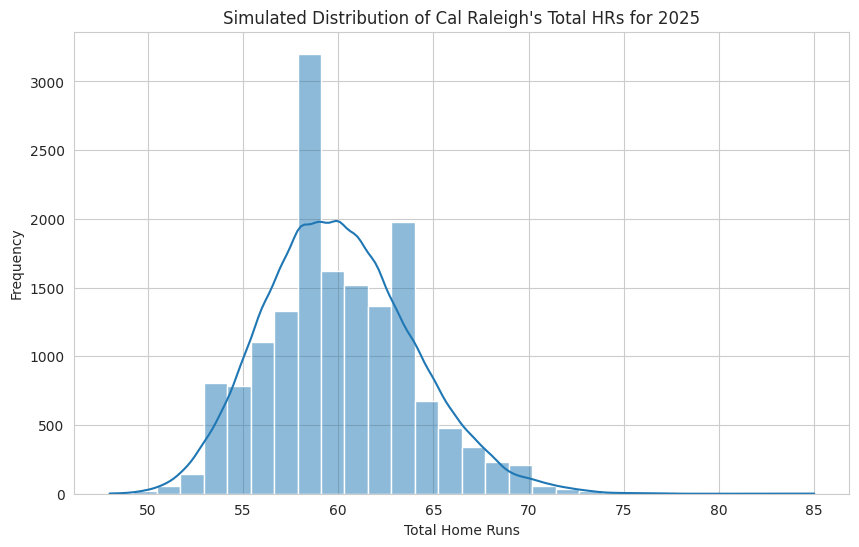


--- Simulation Results (Bayesian Update) ---
Current HRs (as of 2025-08-19): 47
Estimated Remaining PA: 172
Mean of Simulated Total HRs: 60.06
Median of Simulated Total HRs: 60.00
95% Credible Interval for Total HRs: [53, 68]


In [22]:
print("\n--- Running Bayesian Update Simulation (Approach 2) ---")

# Step A: Define Cal Raleigh's 2025 observed stats
# This will be used as the observed data in the likelihood function
# Stats as of 2025-08-19
cal_raleigh_2025_stats = {'Name': 'Cal Raleigh', 'HR': 47, 'PA': 543}

# Step B: Run the Bayesian Model (MCMC)
# The posterior now combines the league prior and Cal's impressive 2025 performance
idata_2025 = run_beta_binomial_model(cal_raleigh_2025_stats, prior_alpha, prior_beta)

# Step C: Simulate remaining season outcomes
# Estimate remaining games = 162 (full season) - 123 (games played) = 39 games
# Estimated PA per game = 543 PA / 123 games = ~4.4 PA/game
# Estimated remaining PA = 39 games * 4.4 PA/game = ~172 PA
future_pa = 172
simulated_hrs_remaining = simulate_season(idata_2025, future_pa)
simulated_total_hrs = cal_raleigh_2025_stats['HR'] + simulated_hrs_remaining

# Step D: Visualize and Summarize Results
plt.figure(figsize=(10, 6))
sns.histplot(simulated_total_hrs, kde=True, bins=30)
plt.title('Simulated Distribution of Cal Raleigh\'s Total HRs for 2025')
plt.xlabel('Total Home Runs')
plt.ylabel('Frequency')
plt.show()

print("\n--- Simulation Results (Bayesian Update) ---")
print(f"Current HRs (as of 2025-08-19): {cal_raleigh_2025_stats['HR']}")
print(f"Estimated Remaining PA: {future_pa}")
print(f"Mean of Simulated Total HRs: {np.mean(simulated_total_hrs):.2f}")
print(f"Median of Simulated Total HRs: {np.median(simulated_total_hrs):.2f}")
print(f"95% Credible Interval for Total HRs: [{np.percentile(simulated_total_hrs, 2.5):.0f}, {np.percentile(simulated_total_hrs, 97.5):.0f}]")